# Capstone: Forecasting the number of antidiabetic drug prescriptions in Australia

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Dataset

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/AusAntidiabeticDrug.csv')
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      204 non-null    object 
 1   y       204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


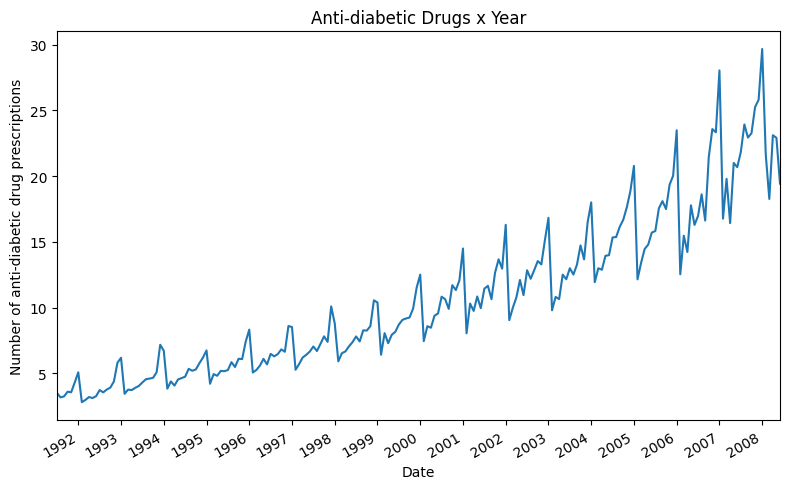

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.set_title('Anti-diabetic Drugs x Year')
ax.set_xlim(0, 203)  # 204 points

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

*Monthly number of antidiabetic drug prescriptions in Australia between 1991 and 2008.*

### Exploration

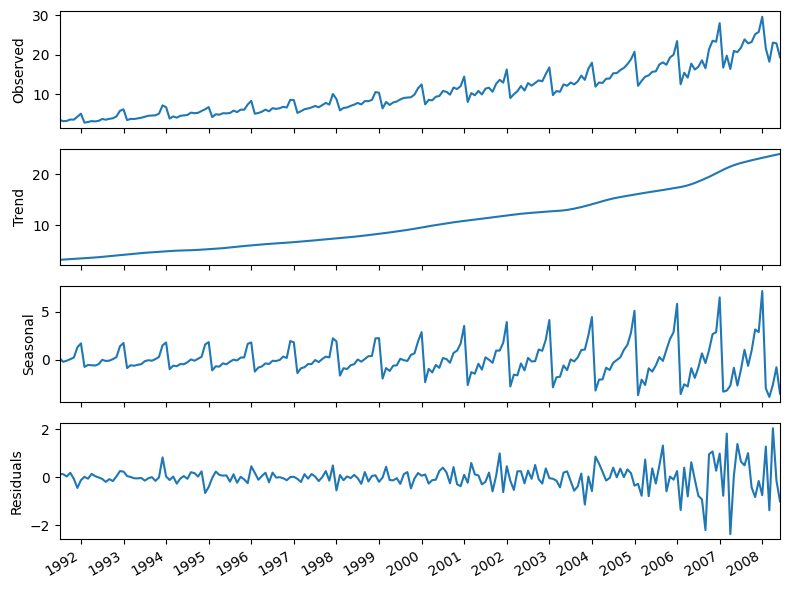

In [9]:
decomposition = STL(df.y, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax1.set_xlim(0, 203) 

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax2.set_xlim(0, 203) 

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_xlim(0, 203) 

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
ax4.set_xlim(0, 203) 

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

*Time series decomposition on the antidiabetic drug prescriptions dataset. The first plot shows the
observed data. The second plot shows the trend component, which tells us that the number of antidiabetic drug
prescriptions is increasing over time. The third plot shows the seasonal component, where we can see a repeating
pattern over time, indicating the presence of seasonality. The last plot shows the residuals, which are variations
that are not explained by the trend of the seasonal component.*

### Modeling

In [12]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df.y)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 3.1451856893067376
p-value: 1.0

p-value > alpha; H0: Not Stationary


In [13]:
# First-Order differencing
eps_diff1 = np.diff(df.y, n=1)

ad_fuller_result1 = adfuller(eps_diff1)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -2.4951721474496713
p-value: 0.11665341686470454

p-value > alpha; H0: Not Stationary


In [14]:
# Second-Order differencing
sea_diff2 = np.diff(eps_diff1, n=12) # Seasonal differencing. Since we have monthly data, m = 12, 
                                     # so the seasonal difference is the difference between two values that are 12 timesteps apart

ad_fuller_result2 = adfuller(sea_diff2)

print(f'ADF Statistic: {ad_fuller_result2[0]}')
print(f'p-value: {ad_fuller_result2[1]}')
print()

if ad_fuller_result2[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -19.848440095625072
p-value: 0.0

p-value < alpha; Ha: Stationary


    Since we took one difference and one seasonal difference, this means that d=1 and D=1. 
    Finally, since we have monthly data, m=12.

### Split training and test datasets

In [17]:
train = df.y[:168]
test = df.y[168:]

print(len(train))
print(len(test))

168
36


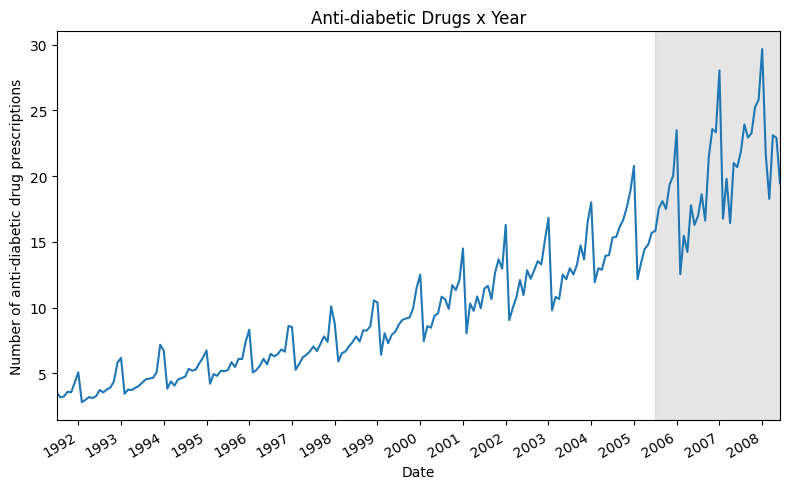

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.set_title('Anti-diabetic Drugs x Year')
ax.axvspan(168, 204, color='#808080', alpha=0.2)
ax.set_xlim(0, 203)  # 204 points

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

### Selecting the model: SARIMA(p,1,q)(P,1,Q)12

In [63]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [56]:
                     # Could be:
ps = range(0, 4, 1)  # ps = range(0, 5, 1)
qs = range(0, 4, 1)  # qs = range(0, 5, 1)
Ps = range(0, 4, 1)  # Ps = range(0, 5, 1)
Qs = range(0, 4, 1)  # Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1   #<====
D = 1   #<====
s = 12  #<====

In [58]:
SARIMA_result_df = optimize_SARIMAX(train, None, order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(2, 4, 1, 3)",271.216195
2,"(3, 3, 1, 3)",271.300101
3,"(4, 1, 1, 3)",272.145294
4,"(0, 4, 1, 3)",272.152379
...,...,...
620,"(0, 0, 0, 4)",351.680917
621,"(0, 0, 2, 4)",353.252584
622,"(0, 0, 0, 1)",354.751719
623,"(0, 0, 1, 0)",357.173706


Model:

    SARIMA (p,d,q)(P,D,Q,s)
    SARIMA (3,1,1)(1,1,3,12)

### Fitting the Model

In [68]:
# Define a SARIMAX model with specified parameters: (3,1,1)(1,1,3,12)
SARIMA_model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)

# Fit the model
SARIMA_model_fit = SARIMA_model.fit(disp=False)

# Display the summary
SARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  168
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -126.476
Date:                                    Thu, 20 Feb 2025   AIC                            270.951
Time:                                            13:39:12   BIC                            298.342
Sample:                                                 0   HQIC                           282.077
                                                    - 168                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.091      0.748      0.455      -0.110       0.246
ar.L2          0.2449      0.092      2.655      0.008       0.064       0.426
ar.L3          0.2216      0.081      2.722      0.006       0.062       0.381
ma.L1         -0.9469      0.049    -19.208      0.000      -1.043      -0.850
ar.S.L12       0.9102      0.170      5.346      0.000       0.576       1.244
ma.S.L12      -1.2851      0.236     -5.441      0.000      -1.748      -0.822
ma.S.L24       0.1572      0.174      0.903      0.367      -0.184       0.498
ma.S.L36       0.2689      0.128      2.105      0.035       0.018       0.519
sigma2         0.2738      0.035      7.804      0.000       0.205       0.343
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.76
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               4.19   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Residual Analysis

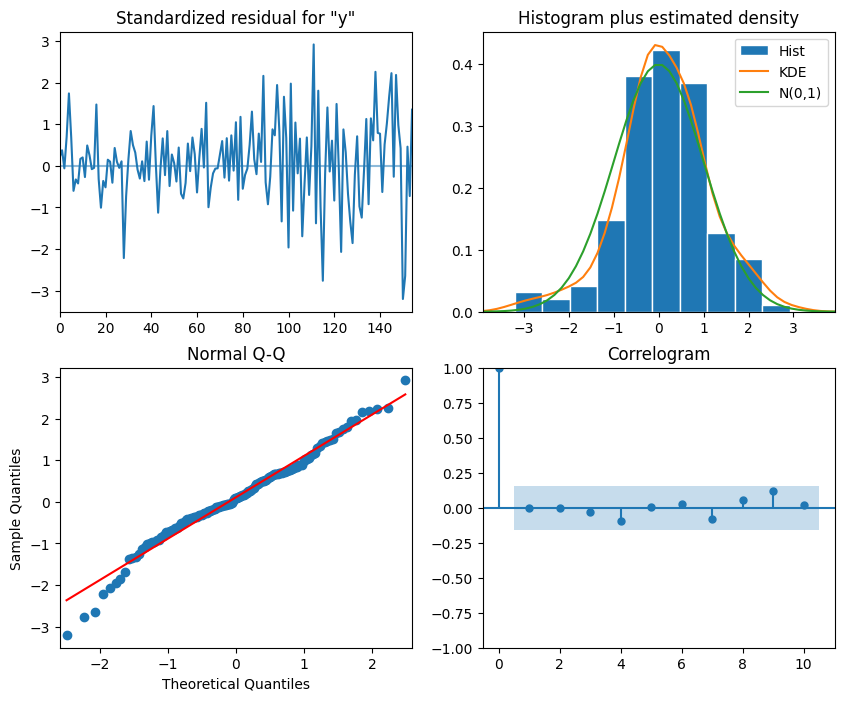

In [70]:
# Diagnostic plots for the model, including residuals and other model checks
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [72]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract the residuals (errors) from the fitted model
residuals = SARIMA_model_fit.resid 

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.436773,0.508684
2,0.627597,0.730666
3,0.646125,0.885797
4,2.258473,0.688340
5,2.950764,0.707577
6,3.389756,0.758575
7,9.982389,0.189574
8,10.592390,0.225881
9,11.854665,0.221627
10,11.985987,0.285995


### Forecasting

In [78]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False) #<==== SARIMA (3,1,1)(1,1,3,12)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [80]:
pred_df = df[168:]  # Test period (36)

pred_df

,ds,y
168,2005-07-01,15.829550
169,2005-08-01,17.554701
170,2005-09-01,18.100864
171,2005-10-01,17.496668
172,2005-11-01,19.347265
173,2005-12-01,20.031291
174,2006-01-01,23.486694
175,2006-02-01,12.536987
176,2006-03-01,15.467018
177,2006-04-01,14.233539


In [82]:
TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

pred_df

,ds,y,last_season
168,2005-07-01,15.829550,15.339097
169,2005-08-01,17.554701,15.370764
170,2005-09-01,18.100864,16.142005
171,2005-10-01,17.496668,16.685754
172,2005-11-01,19.347265,17.636728
173,2005-12-01,20.031291,18.869325
174,2006-01-01,23.486694,20.778723
175,2006-02-01,12.536987,12.154552
176,2006-03-01,15.467018,13.402392
177,2006-04-01,14.233539,14.459239


In [84]:
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.745813
169,2005-08-01,17.554701,15.370764,16.619358
170,2005-09-01,18.100864,16.142005,17.255323
171,2005-10-01,17.496668,16.685754,18.107517
172,2005-11-01,19.347265,17.636728,18.722217
173,2005-12-01,20.031291,18.869325,19.885888
174,2006-01-01,23.486694,20.778723,22.216389
175,2006-02-01,12.536987,12.154552,13.544393
176,2006-03-01,15.467018,13.402392,14.972381
177,2006-04-01,14.233539,14.459239,15.593465


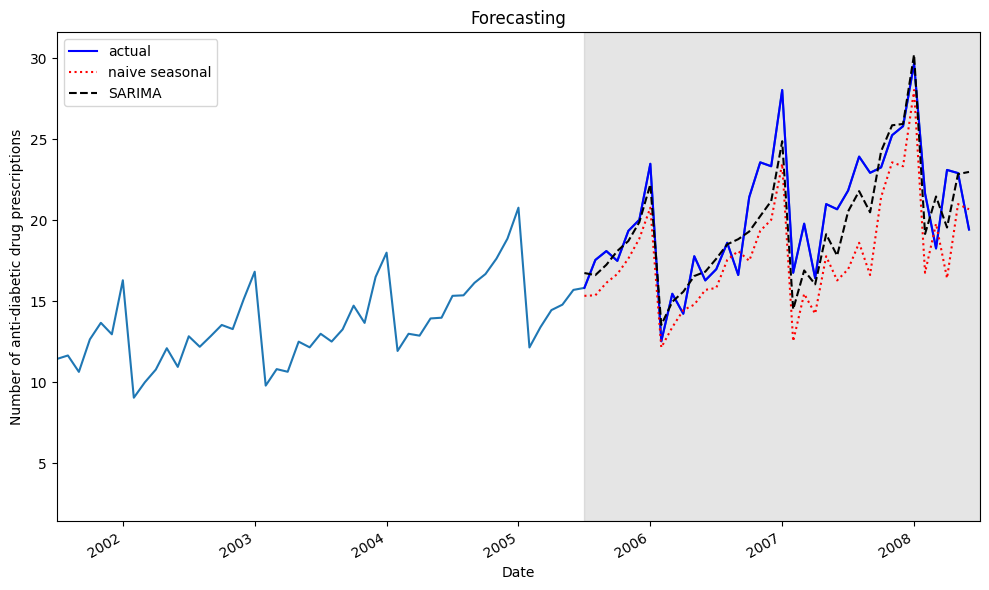

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.set_title('Forecasting')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()

### Evaluate

In [91]:
# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [93]:
# Calculate MAPE for each forecast
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

# Display MAPE results
print(f' MAPE for Naive Baseline: {mape_naive_seasonal:.2f}')
print(f'MAPE for SARIMA Forecast: {mape_SARIMA:.2f}')

 MAPE for Naive Baseline: 12.69
MAPE for SARIMA Forecast: 7.56


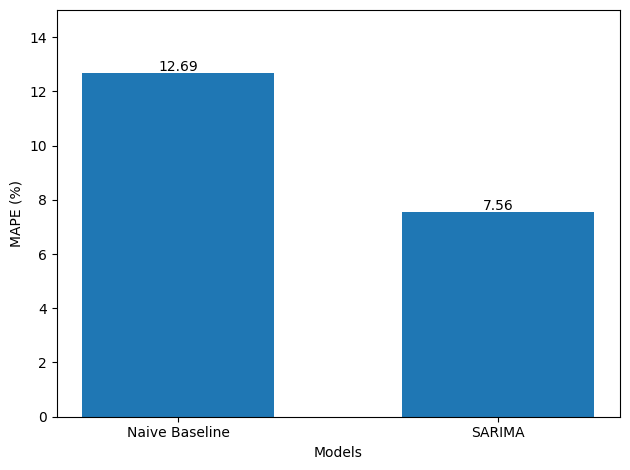

In [99]:
fig, ax = plt.subplots()

x = ['Naive Baseline', 'SARIMA']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

*The MAPE for the naive seasonal forecast and the SARIMA model. Since
the MAPE of the SARIMA model is lower than the MAPE of the baseline, we can
conclude that the SARIMA model should be used to forecast the number of antidiabetic
drug prescriptions.*